<a href="https://colab.research.google.com/github/K-nowing/AudioDVP/blob/master/23W_05_Image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LG-고려대 AI Workshop
# 2023 Winter
--------------------------------------------
## Lab 5. Image Classification
<p style='font-size:20px'><font color = gray> Injae Kim (dna9041@korea.ac.kr)</font></p>

## Agenda
--------------------------------------------
### 1. Introduction - 앞선 강의 자료 참고
### 2. Implementation ResNet

### Reference.
- [Pytorch Tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py)
- [TRANSFER LEARNING FOR COMPUTER VISION TUTORIAL](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)


<br>
<br>

# 2. Implementation (1) ResNet
---

<br>

### Goals.
* 1) ResNet
* 2) Residual Block
* 3) Pretrained Model 활용


## 2.1. ResNet

* 2015년 ILSVRC에서 우승한 CNN 모델로  Microsoft에서 제안함.
* 기존 모델들에서 신경망이 깊어질 수록 오히려 성능이 떨어짐을 관측했고,
* 이를 해결하기위해 skip/shortcut을 더해줌.
* paper: [Deep Residual Learning for Image Recognition](https://arxiv.org/pdf/1512.03385.pdf)



<br>

## 2.2. Residual Block


* 입력값을 출력값에 더해주도록 shortcut을 추가했다는 점이 기존 모델과의 차이점.


### 2.2.1. Residual Building Block

![](https://raw.githubusercontent.com/jarvislabsai/blog/master/build_resnet34_pytorch/images/res_block1.png)


<br>

## 2.3. Pretrained Model 활용
* pretrained model 불러오기
* 모델에 학습시켜 분류할 데이터를 준비
* fine tuning
<br>
<img src = "https://i.ibb.co/Pg62W6D/resnet-2.png" width = "80%" height = "60%" align='left'>  

### 2.3.1. Packages

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

### 2.3.2. Prepare Data

In [ ]:
# 모델 학습에 사용하기 위해 데이터변형 준비.
train_transforms = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
val_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [ ]:
!git clone https://github.com/K-nowing/LG_workshop.git
# 데이터가 저장된 경로
data_dir = './LG_workshop/hymenoptera_data'
assert os.path.exists(data_dir), "데이터 경로가 잘못됐습니다."

# 데이터셋
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), train_transforms)
val_dataset = datasets.ImageFolder(os.path.join(data_dir, 'val'), val_transforms)
print("\n", train_dataset)
print("\n", val_dataset)
print(f"\n한 데이터의 형태:({train_dataset[0][0].shape}, {type(train_dataset[0][1])}")

# 데이터로더
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=False)

print("\n학습 데이터셋의 길이:",len(train_dataset))
print("테스트 데이터셋의 길이:",len(val_dataset))

In [ ]:
# 데이터 개수
train_size = len(train_dataset) 
val_size = len(val_dataset)

# 학습데이터 클래스
class_names = train_dataset.classes
print("\n학습할 데이터 클래스 리스트:",class_names)

# GPU 연결
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("연결된 GPU 자원:",device)


학습할 데이터 클래스 리스트: ['ants', 'bees']
연결된 GPU 자원: cuda:0


가져온 한 배치에 있는 데이터 형태: torch.Size([4, 3, 224, 224]) 



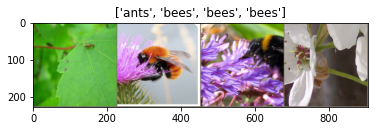

In [ ]:
# 불러온 데이터 확인
def imshow(input, title=None):
    """Imshow for Tensor."""
    input = input.numpy().transpose((1, 2, 0)) # 데이터의 채널 순서 변경
    mean = np.array([0.485, 0.456, 0.406]) # 각 채널의 픽셀값들의 평균
    std = np.array([0.229, 0.224, 0.225]) # 각 채널의 픽셀값들의 표준편차
    input = std * input + mean # 이미지의 각 채널의 픽셀값들의 분포가 위의 평균과 표준편차를 갖는 분포를 따르도록 바꿔줌
    input = np.clip(input, 0, 1) # 이미지의 픽셀값 중, 1보다 큰값을 모두 1로 바꿔줌
    plt.imshow(input) # 지금까지 변형시킨 이미지를 출력함.
    if title is not None: 
        plt.title(title) # 이미지 상단에 텍스트 출력.
    plt.pause(0.001)  # 갱신이 될 때까지 잠시 대기.


# 학습 데이터의 한 배치를 얻음.
inputs, classes = next(iter(train_dataloader))
print("가져온 한 배치에 있는 데이터 형태:",inputs.shape,"\n")

# 배치로부터 격자 형태의 이미지를 만듭니다.
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

### 2.3.3. Model
- ResNet-18
- 사전학습된 모델 사용하기
  - `pretrained =`
    - `True` : 사전에 학습된 모델 사용.
    - `False` : 사전에 학습된 모델 사용 안함.
- [이외의 사용 가능한 다른 모델들](https://pytorch.org/vision/stable/models.html)

In [ ]:
# models.사용할 모델(pretrained=사용여부선택)

resnet18_pretrained = models.resnet18(pretrained=True)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

### 2.3.4. Prepare model for training
```
모델의 마지막 fc layer에서는 최종적으로 classification
```

In [ ]:
# 학습에 사용하기 위해 구조 변경
in_ftrs = resnet18_pretrained.fc.in_features
out_ftrs = resnet18_pretrained.fc.out_features
print("(변경 전) model의 fc layer에 입력되는 feature vector의 크기:",in_ftrs)
print("(변경 전) model의 fc layer에서 출력되는 feature vector의 크기:",out_ftrs)
resnet18_pretrained.fc = nn.Linear(in_ftrs, len(class_names))
print("(변경 후) model의 fc layer에서 출력되는 feature vector의 크기:",resnet18_pretrained.fc.out_features)
model = resnet18_pretrained.to(device)

(변경 전) model의 fc layer에 입력되는 feature vector의 크기: 512
(변경 전) model의 fc layer에서 출력되는 feature vector의 크기: 1000
(변경 후) model의 fc layer에서 출력되는 feature vector의 크기: 2


In [ ]:
# Loss 함수
criterion = nn.CrossEntropyLoss()

# Optimizer: 최적화 함수
# lr: 미분값을 얼마나 이동시킬 것인가
# momentum: 미분값에 관성을 주어 local minimum 문제를 해결하기 위함
# 마지막 레이어만 학습 시키기. (resnet18_pretrained.fc.parameters())
optimizer = optim.SGD(resnet18_pretrained.fc.parameters(), lr=0.0001, momentum=0.9)

num_epochs = 10


### 2.3.5. Training

In [ ]:
since = time.time()

best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0

for epoch in range(num_epochs):
    print(f'Epoch {epoch}/{num_epochs - 1}')
    print('-' * 10)
    
    model.train()   # 모델을 학습 모드로 설정
    
    running_loss = 0.0
    running_corrects = 0
    for inputs, labels in train_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # 매개변수 경사도를 0으로 설정
        optimizer.zero_grad()

        # 순전파
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)


        # 역전파 + 최적화
        loss.backward()
        optimizer.step()

        # 통계
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        
    epoch_loss = running_loss / train_size
    epoch_acc = running_corrects.double() / train_size

    print(f'train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    
    model.eval()   # 모델을 평가 모드로 설정
    
    running_loss = 0.0
    running_corrects = 0
    with torch.no_grad():   # 학습을 안하므로 연산 기록을 추적할 필요 없음.
        for inputs, labels in val_dataloader:

            inputs = inputs.to(device)
            labels = labels.to(device)

            # 매개변수 경사도를 0으로 설정
            optimizer.zero_grad()

            # 순전파
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)


            # 통계
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / val_size
        epoch_acc = running_corrects.double() / val_size

        print(f'val Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # 모델을 깊은 복사(deep copy)함
        if epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())

    print()

time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))
print(f'Best val Acc: {best_acc:4f}')

# 가장 나은 모델 가중치를 불러옴
model.load_state_dict(best_model_wts)

Epoch 0/9
----------
train Loss: 0.6316 Acc: 0.6680
val Loss: 0.4905 Acc: 0.7974

Epoch 1/9
----------
train Loss: 0.5874 Acc: 0.6762
val Loss: 0.4077 Acc: 0.8889

Epoch 2/9
----------
train Loss: 0.5602 Acc: 0.7172
val Loss: 0.3438 Acc: 0.8954

Epoch 3/9
----------
train Loss: 0.4772 Acc: 0.7664
val Loss: 0.3028 Acc: 0.9216

Epoch 4/9
----------
train Loss: 0.4641 Acc: 0.8074
val Loss: 0.3052 Acc: 0.9216

Epoch 5/9
----------
train Loss: 0.4470 Acc: 0.7869
val Loss: 0.2571 Acc: 0.9412

Epoch 6/9
----------
train Loss: 0.4127 Acc: 0.8484
val Loss: 0.2795 Acc: 0.9150

Epoch 7/9
----------
train Loss: 0.4594 Acc: 0.7787
val Loss: 0.2380 Acc: 0.9412

Epoch 8/9
----------
train Loss: 0.4099 Acc: 0.8074
val Loss: 0.2316 Acc: 0.9412

Epoch 9/9
----------
train Loss: 0.4434 Acc: 0.7869
val Loss: 0.2237 Acc: 0.9477

Training complete in 0m 54s
Best val Acc: 0.947712


<All keys matched successfully>

### 2.3.5. 결과 확인

In [ ]:
def normalize_data(input):
    input = input.numpy().transpose((1, 2, 0)) # 데이터의 채널 순서 변경
    mean = np.array([0.485, 0.456, 0.406]) # 각 채널의 픽셀값들의 평균
    std = np.array([0.229, 0.224, 0.225]) # 각 채널의 픽셀값들의 표준편차
    input = std * input + mean # 이미지의 각 채널의 픽셀값들의 분포가 위의 평균과 표준편차를 갖는 분포를 따르도록 바꿔줌
    input = np.clip(input, 0, 1) # 이미지의 픽셀값 중, 1보다 큰값을 모두 1로 바꿔줌
    
    return input


def visualize_model(model, num_images=6):
    was_training = model.training # 이전까지의 모델 모드 기록
    model.eval() # 모델을 평가모드로 전환.
    images_so_far = 0

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs,1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                out_img = normalize_data(inputs.cpu().data[j])
                plt.figure(figsize=(4,4))
                plt.imshow(out_img)
                plt.title(f'predicted: {class_names[preds[j]]}\nground truth: {class_names[labels[j]]}')
                plt.axis('off')
                print()

                if images_so_far==num_images:
                    break
            if images_so_far==num_images:
                break
    plt.show()

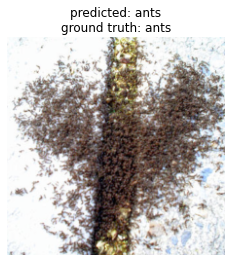

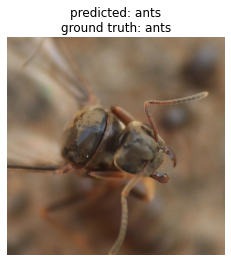

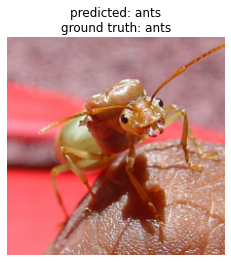

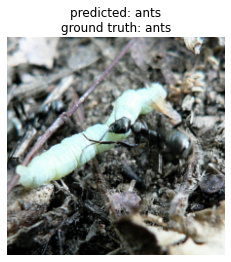

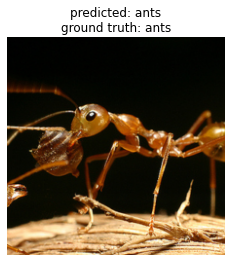

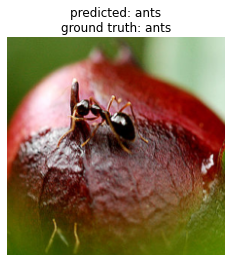

In [ ]:
visualize_model(model)